In [2]:
import jax.numpy as jnp
import jax
from functools import partial

from feadme.parser import Template, Parameter, Line, Shape, Disk, Mask
from feadme.compose import disk_model
import numpy as np
from numpyro.infer import MCMC, NUTS, init_to_sample
import json
import pickle
from pathlib import Path
from numpyro.infer import init_to_median
from astropy.table import Table
import pandas as pd

finfo = np.finfo(float)

4


In [3]:
# %matplotlib ipympl

In [4]:
from astropy.table import Table

tab = Table.read("/Users/nmearl/research/tde_agn_comparison/data/ZTF18aahiqst_subtracted.txt", format='ascii.basic', names=('x', 'y', 'uncertainty'))
test_wave = tab['x'] / (1 + 0.07492849221937987)
test_flux = tab['y']
test_flux_err = tab['uncertainty']

mask = (test_wave > 6400) & (test_wave < 6700)
# hbmask = (test_wave > 4861.333 - 75) & (test_wave < 4861.333 + 62)
# mask = hamask | hbmask
#
test_wave = test_wave[mask]
test_flux = test_flux[mask]
test_flux_err = test_flux_err[mask]

hamask = (test_wave > 6400) & (test_wave < 6700)

Table({"wave": test_wave, "flux": test_flux, "flux_err": test_flux_err}).write("test_data.csv", format="ascii.csv", overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nmearl/research/tde_agn_comparison/data/ZTF18aahiqst_subtracted.txt'

In [4]:
(tab['x'][np.argmax(tab['y'])] - 6562.819) / 6562.819
finfo.eps, finfo.tiny

NameError: name 'tab' is not defined

In [7]:
test_template = Template(
    name="test_template",
    disk_profiles=[
        Disk(
            name="halpha_disk",
            mask=[Mask(lower_limit=6400, upper_limit=6700)],
            center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
            inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3),
            delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=1e1, high=1e4),
            inclination=Parameter(name="inclination", distribution="normal", low=finfo.eps, high=np.pi / 2 - finfo.eps, loc=np.pi / 4, scale=np.pi / 8),
            sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e4),
            q=Parameter(name="q", distribution="uniform", low=finfo.eps, high=4),
            eccentricity=Parameter(name="eccentricity", distribution="uniform", low=finfo.eps, high=1 - finfo.eps),
            apocenter=Parameter(name="apocenter", distribution="normal", low=finfo.eps, high=2 * np.pi - finfo.eps, loc=np.pi, scale=np.pi / 4),
            scale=Parameter(name="scale", distribution="uniform", low=0, high=90),
            offset=Parameter(name="offset", distribution="uniform", low=0, high=5)
        ),
        # Disk(
        #     name="hbeta_disk",
        #     mask=hbmask,
        #     center=Parameter(name="center", distribution="uniform", low=4857, high=4866),
        #     inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=1e4, shared="halpha_disk"),
        #     outer_radius=Parameter(name="outer_radius", distribution="log_uniform", low=1e3, high=1e5, shared="halpha_disk"),
        #     inclination=Parameter(name="inclination", distribution="uniform", low=0, high=np.pi / 2, shared="halpha_disk"),
        #     sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e3, shared="halpha_disk"),
        #     q=Parameter(name="q", distribution="uniform", low=0.5, high=3, shared="halpha_disk"),
        #     eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1, shared="halpha_disk"),
        #     apocenter=Parameter(name="apocenter", distribution="uniform", low=0, high=2 * np.pi, shared="halpha_disk"),
        # ),
    ],
    line_profiles=[
        Line(
            name="halpha_narrow",
            profile=Shape.gaussian,
            center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=1, shared="halpha_disk"),
            amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=90),
            vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3),
        ),
        Line(
            name="niir_narrow",
            profile=Shape.gaussian,
            center=Parameter(name="center", distribution="normal", low=6583.46 - 5, high=6583.46 + 5, loc=6583.46, scale=1),
            amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=90),
            vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, shared="halpha_narrow"),
        ),
        Line(
            name="niil_narrow",
            profile=Shape.gaussian,
            center=Parameter(name="center", distribution="normal", low=6548.05 - 5, high=6548.05 + 5, loc=6548.05, scale=1),
            amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=90),
            vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, shared="halpha_narrow"),
        ),
        Line(
            name="siir_narrow",
            profile=Shape.gaussian,
            center=Parameter(name="center", distribution="normal", low=6730.81 - 5, high=6730.81 + 5, loc=6730.81, scale=1),
            amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=90),
            vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, shared="halpha_narrow"),
        ),
        Line(
            name="siil_narrow",
            profile=Shape.gaussian,
            center=Parameter(name="center", distribution="normal", low=6716.44 - 5, high=6716.44 + 5, loc=6716.44, scale=1),
            amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=90),
            vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, shared="halpha_narrow"),
        ),
    ],
    white_noise=Parameter(name="white_noise", distribution="log_uniform", low=1e-5, high=1),
)

with open("/Users/nmearl/research/tde_agn_comparison/test_template.json", "w") as f:
    json.dump(test_template.model_dump(), f)

In [ ]:
mask=[Mask(lower_limit=6400, upper_limit=6450), Mask(lower_limit=6500, upper_limit=6700)]
np.bitwise_or(*[np.bitwise_and(test_wave > m.lower_limit, test_wave < m.upper_limit) for m in mask])

In [ ]:
import numpyro
from astropy.time import Time
from numpyro.infer import Predictive, init_to_feasible
import matplotlib.pyplot as plt
import astropy.uncertainty as unc

import corner
import arviz as az


def plot(mcmc, disk_model, wave, flux, flux_err, rng_key=None):
    rng_key = rng_key if rng_key is not None else jax.random.PRNGKey(0)

    posterior_samples = mcmc.get_samples()
    predictive = Predictive(disk_model, posterior_samples=posterior_samples)
    # X = np.linspace(6562.819 - 150, 6562.819 + 150, 1000)
    y_pred = predictive(rng_key, wave=wave, flux=None, flux_err=flux_err
                        )["obs"]

    real_dist = unc.Distribution(y_pred.T)
    lower_lim, median, upper_lim = real_dist.pdf_percentiles([16, 50, 84])

    f, ax = plt.subplots()

    # ax.plot(wave, y_pred)
    ax.plot(wave, median)
    ax.fill_between(wave, lower_lim, upper_lim, alpha=0.5)
    ax.plot(wave, flux)
    # ax.set_xlim(6450, 6700)

    # for n in np.random.default_rng(0).integers(len(y_pred), size=100):
    #     ax.plot(wave, y_pred[n], ".", color="C0", alpha=0.1)

    f.savefig("test.png")

    idata = az.from_numpyro(mcmc)

    f = corner.corner(
        posterior_samples,
        var_names=[x for x in idata.posterior.keys() if '_base' not in x],
        labels=[x for x in idata.posterior.keys() if '_base' not in x],
        quantiles=[0.16, 0.5, 0.84],
        smooth=1,
    )

    f.savefig(f"corner_plot.png")


def run(template_file, data_file, output_dir=None, label=None):
    with open(template_file, "r") as f:
        loaded_data = json.load(f)
        template = Template(**loaded_data)

    data = Table.read(data_file, format="ascii.csv")

    label = f"{Time.now().isot}" if label is None else label

    wave = data["wave"]
    flux = data["flux"]
    flux_err = data["flux_err"]

    profile_ref = {}

    for prof in template.disk_profiles + template.line_profiles:
        profile_ref.setdefault(prof.name, {})

        for field in prof.model_fields:
            field_ref = getattr(prof, field)

            if isinstance(field_ref, Parameter):
                profile_ref[prof.name][field] = {}
                profile_ref[prof.name][field].setdefault("distribution", field_ref.distribution.name)
                profile_ref[prof.name][field].setdefault("fixed", field_ref.fixed)
                profile_ref[prof.name][field].setdefault("shared", field_ref.shared)
                profile_ref[prof.name][field].setdefault("low", field_ref.low)
                profile_ref[prof.name][field].setdefault("high", field_ref.high)
                profile_ref[prof.name][field].setdefault("loc", field_ref.loc)
                profile_ref[prof.name][field].setdefault("scale", field_ref.scale)

    in_disk = partial(
        disk_model,
        template=template.model_dump(),
        parameters={
            prof.name: {
                k: v
                for k, v in profile_ref[prof.name].items()
                if v["shared"] is None
            } for prof in template.disk_profiles + template.line_profiles
        },
        shared_parameters={
            prof.name: {
                k: v
                for k, v in profile_ref[prof.name].items()
                if v["shared"] is not None
            } for prof in template.disk_profiles + template.line_profiles
        },
        masks={
            prof.name: {
                "mask": jnp.asarray(np.bitwise_or(*[np.bitwise_and(test_wave > m.lower_limit, test_wave < m.upper_limit) for m in mask])
),
                "wave": jnp.asarray(wave[np.bitwise_or(*[np.bitwise_and(test_wave > m.lower_limit, test_wave < m.upper_limit) for m in mask])
])
            } for prof in template.disk_profiles
        }
    )

    nuts_kernel = NUTS(in_disk)#, init_strategy=init_to_feasible())
    # disk_model(template, wave, flux)
    rng_key = jax.random.PRNGKey(0)

    if not Path(output_dir).exists():
        Path(output_dir).mkdir()

    if Path(f"{output_dir}/{label}.pkl").exists():
        with open(f"{output_dir}/{label}.pkl", "rb") as f:
            mcmc = pickle.load(f)
    else:
        mcmc = MCMC(
            nuts_kernel,
            num_warmup=1000,
            num_samples=2000,
            num_chains=jax.local_device_count(),
            chain_method="vectorized" if jax.local_device_count() == 1 else "parallel",
        )

        with numpyro.validation_enabled():
            mcmc.run(
                rng_key,
                wave=jnp.asarray(wave),
                flux=jnp.asarray(flux),
                flux_err=jnp.asarray(flux_err),
            )

        with open(f"{output_dir}/{label}.pkl", "wb") as f:
            pickle.dump(mcmc, f)

    plot(mcmc, in_disk, wave, flux, flux_err, rng_key)

    mcmc.print_summary()

run("test_template.json", "test_data.csv", output_dir="ZTF18aahiqst-output", label="ZTF18aahiqst")

In [ ]:
# test_template.line_profiles[0].profile.name == 'lorentzian'

In [9]:
import jax.numpy as jnp
from jax.scipy.stats import norm as jnorm
from scipy.stats import truncnorm

def truncnorm_ppf(u, mu, sigma, a, b):
    """JAX-compatible PPF for truncated normal using NumPy's scipy.stats.norm.ppf."""
    Fa = jnorm.cdf((a - mu) / sigma)  # CDF at lower bound
    Fb = jnorm.cdf((b - mu) / sigma)  # CDF at upper bound

    # Transform uniform sample to truncated normal sample
    return mu + sigma * jnorm.ppf(Fa + u * (Fb - Fa))

# Example usage with JAX
u = jnp.linspace(0, 1, 10)  # 10 uniform samples in [0,1]
mu, sigma = 6563, 10
a, b = 6550, 6576  # Truncation bounds

samples = truncnorm_ppf(u, mu, sigma, a, b)
norm_samples = jnorm.ppf(u, loc=mu, scale=sigma)
print(samples)
print(norm_samples)

# Example usage with NumPy
uu = np.linspace(0, 1, 10)  # 10 uniform samples in [0,1]
samples = truncnorm.ppf(uu, (a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
print(samples)


[6550.         6554.08760605 6557.05234959 6559.56470728 6561.8746612
 6564.1253388  6566.43529272 6568.94765041 6571.91239395 6576.        ]
[         -inf 6550.79359651 6555.35290326 6558.69272701 6561.60289701
 6564.39710299 6567.30727299 6570.64709674 6575.20640349           inf]
[6550.         6554.08760605 6557.05234959 6559.56470728 6561.8746612
 6564.1253388  6566.43529272 6568.94765041 6571.91239395 6576.        ]


In [3]:
import pandas as pd

df = pd.DataFrame([{"a": [1, 2, 3], "b": [4, 5, 6]}, {"a": [1, 2, 3], "b": [4, 5, 6]}])
df

,a,b
0,"[1, 2, 3]","[4, 5, 6]"
1,"[1, 2, 3]","[4, 5, 6]"


In [ ]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

from datetime import date
import blackjax
import multiprocessing


loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)


def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logjac = log_scale
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return logjac + jnp.sum(logpdf)


def logdensity(x):
    return logdensity_fn(**x)


def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3
nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

num_chains = multiprocessing.cpu_count()

inference_loop_multiple_chains = jax.pmap(inference_loop, in_axes=(0, None, 0, None), static_broadcasted_argnums=(1, 3))

initial_positions = {"loc": np.ones(num_chains), "log_scale": np.ones(num_chains)}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

rng_key, sample_key = jax.random.split(rng_key)
sample_keys = jax.random.split(sample_key, num_chains)

pmap_states = inference_loop_multiple_chains(
    sample_keys, nuts.step, initial_states, 2_000
)
_ = pmap_states.position["loc"].block_until_ready()

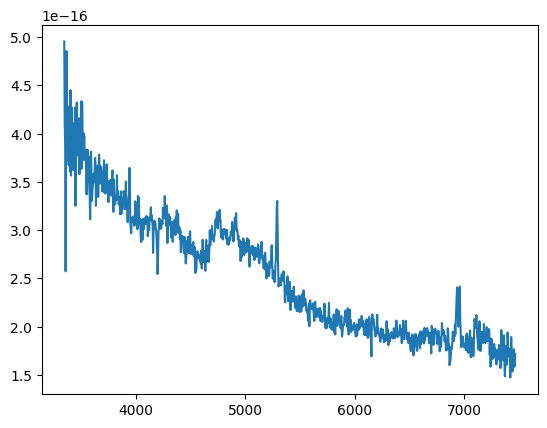

In [8]:
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt


with fits.open("/Users/nmearl/Downloads/archive/ADP.2023-08-16T08:22:16.327.fits") as hdulist:
    data = hdulist[1].data

fig, ax = plt.subplots()

ax.plot(data["WAVE"].T, data["FLUX"].T)

In [7]:
data["WAVE"].T

array([[3344.0847],
       [3348.1667],
       [3352.2488],
       ...,
       [7458.6934],
       [7462.775 ],
       [7466.857 ]], dtype='>f4')